### Variational Quantum Eigensolver (VQE)

We will be solving for this observable
O = 2II - 2XX + 3YY - 3ZZ

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

In [2]:
theta_list = (2 * np.pi * np.random.rand(1,8)).tolist()
print(theta_list)

[[2.0849269121112624, 3.060591805118952, 2.4417157827850793, 2.851981087101313, 1.540834496492882, 2.754523414713051, 0.2807122748818651, 2.434720234672633]]


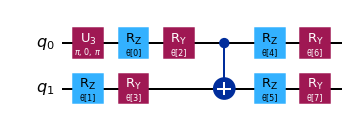

In [10]:
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1
)

ansatz = reference_circuit.compose(variational_form)
ansatz.decompose().draw('mpl')

In [14]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    estimator_job = estimator.run([(ansatz, hamiltonian, [params])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [15]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [19]:
from scipy.optimize import minimize
x0 = np.ones(8)
result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971083
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

In [20]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, Session, Options, QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational = True, simulator = False)


In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout= isa_ansatz.layout)

In [ ]:
with Session(backend = backend) as session:
    session_options = Options()
    estimator = Estimator(session)
    estimator.options.resilience_level = 1
    estimator.options.default_shots = 4096
    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method = "COBYLA")

session.close()
print(result)